<a href="https://colab.research.google.com/github/Jahan08/Advanced-AI-algorithm-practice-hERG-data/blob/main/DNN_tensorflow_hERG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
!pip install rdkit

In [57]:
from pathlib import Path
from warnings import filterwarnings

# Silence some expected warnings
filterwarnings("ignore")

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import MACCSkeys, Draw, rdFingerprintGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

# Neural network specific libraries
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint

%matplotlib inline

Create folder Name data and upload the dataset on that

In [58]:
# Load data
df = pd.read_csv("/content/data/hERG_bioactivity_pIC50.csv", index_col=0)
df = df.reset_index(drop=True)

In [59]:
# Check the dimension and missing value of the data
print("Shape of dataframe : ", df.shape)
df.info()

Shape of dataframe :  (2968, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2968 entries, 0 to 2967
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   canonical_smiles  2968 non-null   object 
 1   Source            2919 non-null   object 
 2   Name              2968 non-null   object 
 3   hERG_uM           2968 non-null   float64
 4   Activity          2968 non-null   int64  
 5   pIC50             2968 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 139.2+ KB


In [60]:
# Look at head
df.head()
# NBVAL_CHECK_OUTPUT

,canonical_smiles,Source,Name,hERG_uM,Activity,pIC50
0,O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc...,J Med Chem,CHEMBL12713,0.0140,1,7.853872
1,O=C(CCCN1CC=C(n2c(=O)[nH]c3ccccc32)CC1)c1ccc(F...,J Med Chem,CHEMBL1108,0.0322,1,7.492144
2,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,J Med Chem,CHEMBL6966,0.1430,1,6.844664
3,CCCCN(CCCC)CCC(O)c1cc2c(Cl)cc(Cl)cc2c2cc(C(F)(...,J Med Chem,CHEMBL1107,0.1960,1,6.707744
4,CCOC(=O)N1CCC(=C2c3ccc(Cl)cc3CCc3cccnc32)CC1,J Med Chem,CHEMBL998,0.1730,1,6.761954


In [61]:
# Keep necessary columns
chembl_df = df[["canonical_smiles", "pIC50"]]
chembl_df.head()
# NBVAL_CHECK_OUTPUT

,canonical_smiles,pIC50
0,O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc...,7.853872
1,O=C(CCCN1CC=C(n2c(=O)[nH]c3ccccc32)CC1)c1ccc(F...,7.492144
2,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,6.844664
3,CCCCN(CCCC)CCC(O)c1cc2c(Cl)cc(Cl)cc2c2cc(C(F)(...,6.707744
4,CCOC(=O)N1CCC(=C2c3ccc(Cl)cc3CCc3cccnc32)CC1,6.761954


In [62]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.
    """

    # Convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=n_bits)
        return np.array(fpg.GetCountFingerprint(mol))
    if method == "morgan3":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=n_bits)
        return np.array(fpg.GetCountFingerprint(mol))
    else:
        print(f"Warning: Wrong method specified: {method}." " Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [63]:
chembl_df["fingerprints_df"] = chembl_df["canonical_smiles"].apply(smiles_to_fp)

# Look at head
print("Shape of dataframe:", chembl_df.shape)
chembl_df.head(3)
# NBVAL_CHECK_OUTPUT

Shape of dataframe: (2968, 3)


,canonical_smiles,pIC50,fingerprints_df
0,O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc...,7.853872,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,O=C(CCCN1CC=C(n2c(=O)[nH]c3ccccc32)CC1)c1ccc(F...,7.492144,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,6.844664,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [64]:
# Split the data into training and test set
x_train, x_test, y_train, y_test = train_test_split(
    chembl_df["fingerprints_df"], chembl_df[["pIC50"]], test_size=0.3, random_state=42
)

# Print the shape of training and testing data
print("Shape of training data:", x_train.shape)
print("Shape of test data:", x_test.shape)
# NBVAL_CHECK_OUTPUT

Shape of training data: (2077,)
Shape of test data: (891,)


In [65]:
def neural_network_model(hidden1, hidden2, hidden3):
    """
    Creating a neural network from two hidden layers
    using ReLU as activation function in the two hidden layers
    and a linear activation in the output layer.

    Parameters
    ----------
    hidden1 : int
        Number of neurons in first hidden layer.

    hidden2: int
        Number of neurons in second hidden layer.

    Returns
    -------
    model
        Fully connected neural network model with two hidden layers.
    """

    model = Sequential()
    # First hidden layer
    model.add(Dense(hidden1, activation="relu", name="layer1"))
    # Second hidden layer
    model.add(Dense(hidden2, activation="relu", name="layer2"))
    # third hidden layer
    model.add(Dense(hidden2, activation="relu", name="layer3"))
    # Output layer
    model.add(Dense(1, activation="linear", name="layer4"))

    # Compile model
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse", "mae"])
    return model

In [66]:
# Neural network parameters
batch_sizes = [16, 32, 64]
nb_epoch = 50
layer1_size = 128
layer2_size = 64
layer3_size= 32

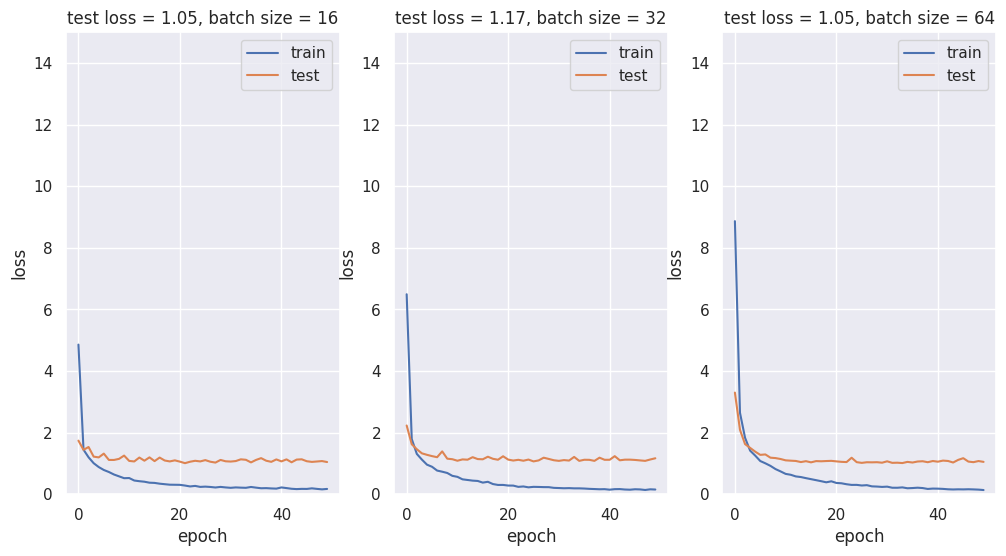

In [67]:
# Plot
fig = plt.figure(figsize=(12, 6))
sns.set(color_codes=True)
for index, batch in enumerate(batch_sizes):
    fig.add_subplot(1, len(batch_sizes), index + 1)
    model = neural_network_model(layer1_size, layer2_size, layer3_size)

    # Fit model on x_train, y_train data
    history = model.fit(
        np.array(list((x_train))).astype(float),
        y_train.values,
        batch_size=batch,
        validation_data=(np.array(list((x_test))).astype(float), y_test.values),
        verbose=0,
        epochs=nb_epoch,
    )
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="test")
    plt.legend(["train", "test"], loc="upper right")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.ylim((0, 15))
    plt.title(
        f"test loss = {history.history['val_loss'][nb_epoch-1]:.2f}, " f"batch size = {batch}"
    )
plt.show()

In [68]:
# Save the trained model
filepath = "/content/data/databest_weights.hdf5"
checkpoint = ModelCheckpoint(
    str(filepath),
    monitor="loss",
    verbose=0,
    save_best_only=True,
    mode="min",
    save_weights_only=True,
)
callbacks_list = [checkpoint]



In [69]:
# Fit the model
model.fit(
    np.array(list((x_train))).astype(float),
    y_train.values,
    epochs=nb_epoch,
    batch_size=16,
    callbacks=callbacks_list,
    verbose=0,
)
model.save("hERG.h5")

In [70]:
# Evalute the model
print(f"Evaluate the model on the test data")
scores = model.evaluate(np.array(list((x_test))), y_test.values, verbose=0)
print(f" loss: {scores[0]:.2f}")
print(f" mse (same as loss): {scores[1]:.2f}")
print(f" mae: {scores[2]:.2f}")

Evaluate the model on the test data
 loss: 0.96
 mse (same as loss): 0.96
 mae: 0.67


In [71]:
# Predict pIC50 values on x_test data
y_pred = model.predict(np.array(list((x_test))))

# Print 5 first pIC50 predicted values
first_5_prediction = [print(f"{value[0]:.2f}") for value in y_pred[0:5]]

28/28 [==============================] - 0s 2ms/step
4.24
3.56
5.12
7.48
6.89


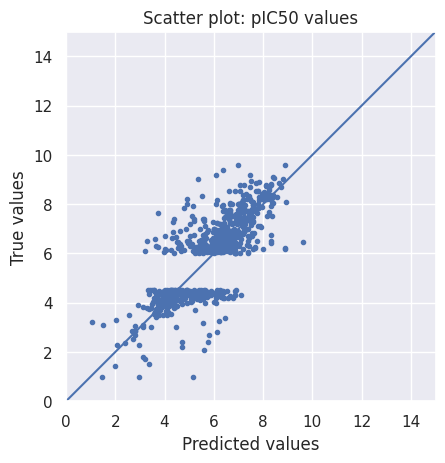

In [73]:
# Scatter plot
limits = 0, 15
fig, ax = plt.subplots()
ax.scatter(y_pred, y_test, marker=".")
lin = np.linspace(*limits, 100)
ax.plot(lin, lin)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("Predicted values")
ax.set_ylabel("True values")
ax.set_title("Scatter plot: pIC50 values")
ax.set_xlim(limits)
ax.set_ylim(limits)
plt.show()

In [74]:
# Load external/unlabeled data set
external_data = pd.read_csv("/content/data/hERG-house.csv", index_col=0)
external_data = external_data.reset_index(drop=True)
external_data.head()
# NBVAL_CHECK_OUTPUT

,canonical_smiles
0,OC(C1=CC=CC=C1)(C2CCN(CCC[C@@H](C3=CC=C(C(C)(C...
1,O=C(NCCCCN1CCN(C2=CC(C(F)(F)F)=NC(C(C)(C)C)=N2...
2,O=C(COC(C=CN1)=NC1=O)NC23CC4C[C@H](C2)C[C@@H](...
3,O=C(C1=CC(CCC(N2)=O)=C2C=C1)NC3=CC(C#CC4=NC=CC...
4,O=C(CN1CCCC[C@@H]1C(N)=O)C(C(N2CC)=O)=C(N(C2=O...


In [75]:
# Convert SMILES strings to MACCS fingerprints
external_data["fingerprints_df"] = external_data["canonical_smiles"].apply(smiles_to_fp)

# Look at head
print("Shape of dataframe : ", external_data.shape)
external_data.head(3)
# NBVAL_CHECK_OUTPUT

Shape of dataframe :  (17, 2)


,canonical_smiles,fingerprints_df
0,OC(C1=CC=CC=C1)(C2CCN(CCC[C@@H](C3=CC=C(C(C)(C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,O=C(NCCCCN1CCN(C2=CC(C(F)(F)F)=NC(C(C)(C)C)=N2...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,O=C(COC(C=CN1)=NC1=O)NC23CC4C[C@H](C2)C[C@@H](...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [76]:
# Load model
model = load_model("/content/hERG.h5")

In [77]:
# Prediction on external/unlabeled data
predictions = model.predict(
    np.array(list((external_data["fingerprints_df"]))).astype(float), callbacks=callbacks_list
)

predicted_pIC50 = pd.DataFrame(predictions, columns=["predicted_pIC50"])
predicted_pIC50_df = external_data.join(predicted_pIC50)

predicted_pIC50_df.head(3)

1/1 [==============================] - 0s 55ms/step


,canonical_smiles,fingerprints_df,predicted_pIC50
0,OC(C1=CC=CC=C1)(C2CCN(CCC[C@@H](C3=CC=C(C(C)(C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.671978
1,O=C(NCCCCN1CCN(C2=CC(C(F)(F)F)=NC(C(C)(C)C)=N2...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4.307853
2,O=C(COC(C=CN1)=NC1=O)NC23CC4C[C@H](C2)C[C@@H](...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.505437


In [78]:
# Save the predicted values in a csv file in the data folder
predicted_pIC50_df.to_csv("/content/predicted_pIC50_df.csv")

In [79]:
# Select top 3 drugs
predicted_pIC50_df = pd.read_csv("/content/predicted_pIC50_df.csv", index_col=0)
top3_drug = predicted_pIC50_df.nlargest(3, "predicted_pIC50")
top3_drug

,canonical_smiles,fingerprints_df,predicted_pIC50
15,O=C(NC1=CC(F)=C(O)C(F)=C1)CCC2CCN(CC3=CC4=C(C=...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,6.993172
14,FC1=C(O)C(F)=CC(NC(CCC2CCN(CCOC3=C(F)C=CC=C3)C...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,6.933792
0,OC(C1=CC=CC=C1)(C2CCN(CCC[C@@H](C3=CC=C(C(C)(C...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,6.671977


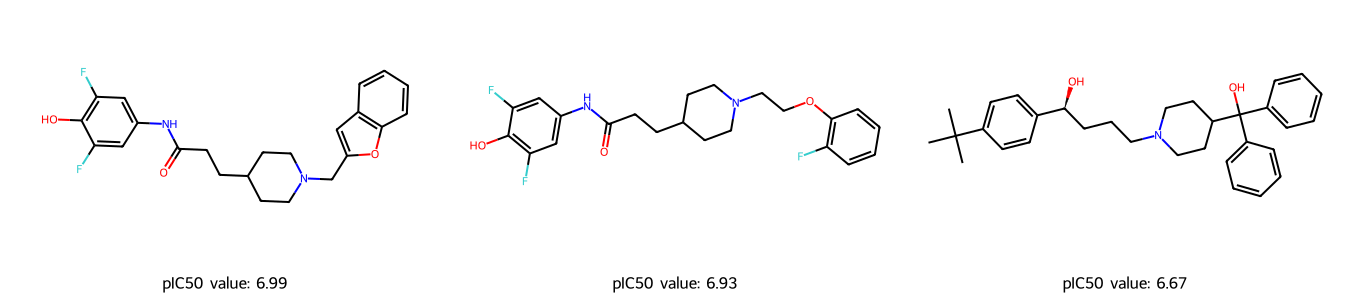

In [80]:
# Draw the drug molecules
highest_pIC50 = predicted_pIC50_df["canonical_smiles"][top3_drug.index]

mols_EGFR = [Chem.MolFromSmiles(smile) for smile in highest_pIC50]
pIC50_EGFR = top3_drug["predicted_pIC50"].tolist()
pIC50_values = [(f"pIC50 value: {value:.2f}") for value in pIC50_EGFR]

Draw.MolsToGridImage(mols_EGFR, molsPerRow=3, subImgSize=(450, 300), legends=pIC50_values)